In [1]:
import numpy as np
from time import time
import os
import sys
import scipy
import math
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import pandas as pd
import psutil
from tqdm import tqdm
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import bigbadbrain as bbb
from scipy.linalg import toeplitz
import scipy.linalg as sl
from scipy.signal import convolve2d
from scipy.signal import convolve
import sklearn
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import cv2

import statsmodels.api as sm

%matplotlib inline

In [2]:
directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_25/func_0'
brain_path = os.path.join(directory, 'brain_zscored_green.nii')
brain = bbb.load_numpy_brain(brain_path)
dims = bbb.get_dims(brain)
print('brain shape is x,y,z,t {}'.format(brain.shape))


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 23.33 sec
brain shape is x,y,z,t (128, 92, 51, 4128)


In [3]:
z=25
X = brain[:,:,z,:].reshape(-1,brain.shape[-1]).T
print('X is time by voxels {}'.format(X.shape))

X is time by voxels (4128, 11776)


In [4]:
pca = PCA().fit(X)
pca_scores = pca.components_
print('Scores is PC by voxel {}'.format(pca_scores.shape))
pca_loadings = pca.transform(X)
print('Loadings is time by PC {}'.format(pca_loadings.shape))

Scores is PC by voxel (4128, 11776)
Loadings is time by PC (4128, 4128)


In [5]:
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac = bbb.load_fictrac(os.path.join(directory, 'fictrac'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 952.31 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 4.33 sec


In [6]:
def interp_fictrac(fictrac, fps, resolution, expt_len, timestamps):
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    
    x_original = np.arange(0,expt_len,camera_rate)
    
    dx = np.asarray(fictrac['dRotLabX'])
    dy = np.asarray(fictrac['dRotLabY'])
    dz = np.asarray(fictrac['dRotLabZ'])
    dx = scipy.signal.savgol_filter(dx,25,3)
    dy = scipy.signal.savgol_filter(dy,25,3)
    dz = scipy.signal.savgol_filter(dz,25,3)
    fictrac_smoothed = np.sqrt(dx*dx + dy*dy + dz*dz)
    
    fictrac_smoothed = np.abs(fictrac_smoothed)
    fictrac_interp_temp = interp1d(x_original, fictrac_smoothed, bounds_error = False)
    xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res
    fictrac_interp = fictrac_interp_temp(timestamps[:,25])

    # Replace Nans with zeros (for later code)
    np.nan_to_num(fictrac_interp, copy=False);
    
    return fictrac_interp

resolution = 10 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
fictrac_interp = interp_fictrac(fictrac, fps, resolution, expt_len, timestamps)
xnew = np.arange(0,expt_len,resolution)

In [34]:
pca_loadings.shape

(4128, 4128)

In [70]:
models_lasso_cv = models

In [77]:
Y_glm = fictrac_interp
models = []
for num_pcs in [10,100,1000,4000]:
    t0 = time()
    models.append({'num_pcs': num_pcs, 'model': LassoLarsIC(criterion='bic'), 'model_type': 'LassoLarsIC'})
    X_glm = pca_loadings[:,:num_pcs]
    models[-1]['model'].fit(X_glm, Y_glm)
    models[-1]['score'] = models[-1]['model'].score(X_glm, Y_glm)
    print('Num PCs: {}, Duration: {} sec'.format(num_pcs, time()-t0))

Num PCs: 10, Duration: 0.029292583465576172 sec
Num PCs: 100, Duration: 0.03615736961364746 sec
Num PCs: 1000, Duration: 0.6235284805297852 sec
Num PCs: 4000, Duration: 2.501013994216919 sec


Text(0.5, 0.98, 'Regularization: LassoLarsIC(AIC)')

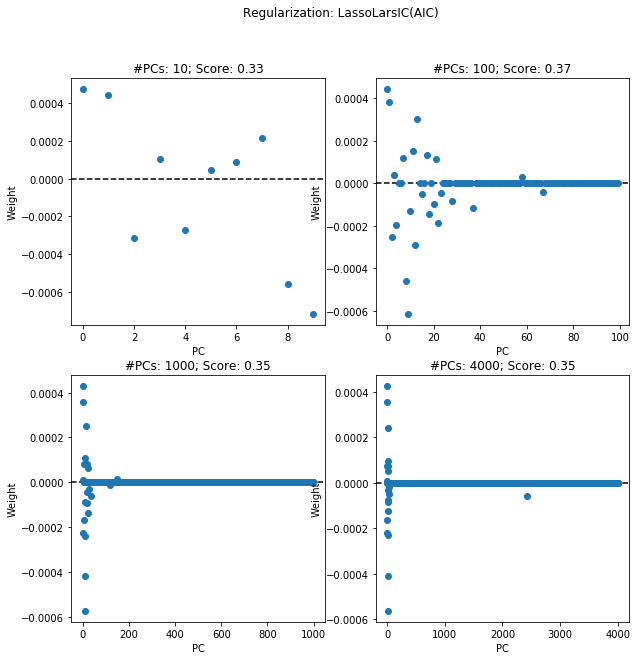

In [78]:
plt.figure(figsize=(10,10))

for i, model in enumerate(models):
    plt.subplot(2,2,i+1)
    plt.axhline(0,color='k',linestyle='--')
    plt.plot(model['model'].coef_,'o')
    plt.title ('#PCs: {}; Score: {:.2f}'.format(model['num_pcs'], model['score']))
    plt.ylabel('Weight')
    plt.xlabel('PC')
    
plt.suptitle('Regularization: LassoLarsIC(AIC)')

(1000, 1400)

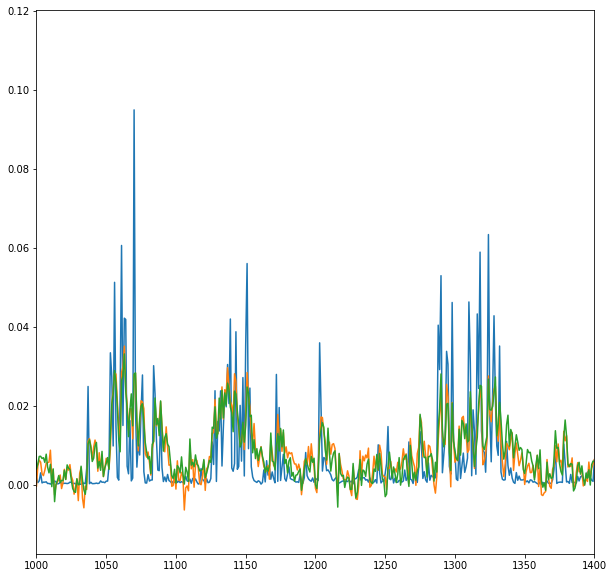

In [89]:
plt.figure(figsize=(10,10))
plt.plot(Y_glm)
plt.plot(models[0]['model'].predict(pca_loadings[:,:10]))
plt.plot(models[1]['model'].predict(pca_loadings[:,:100]))
plt.xlim(1000,1400)

Text(0.5, 0.98, 'Regularization: LassoLarsIC(BIC)')

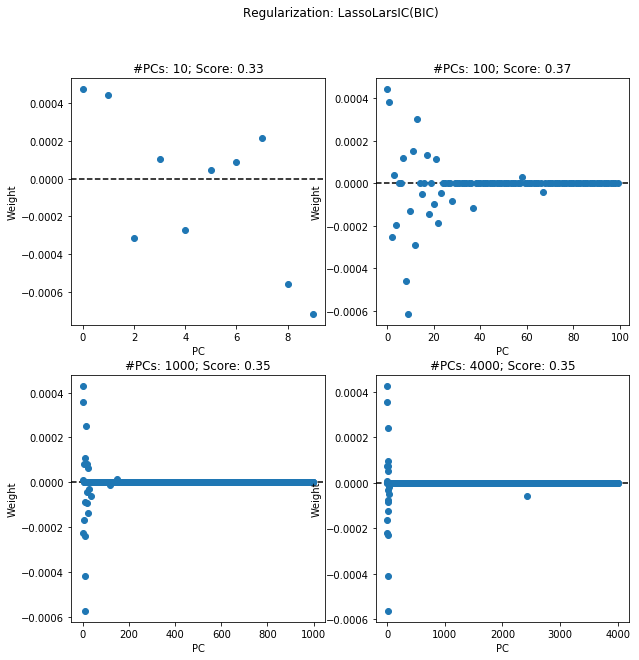

In [74]:
plt.figure(figsize=(10,10))

for i, model in enumerate(models):
    plt.subplot(2,2,i+1)
    plt.axhline(0,color='k',linestyle='--')
    plt.plot(model['model'].coef_,'o')
    plt.title ('#PCs: {}; Score: {:.2f}'.format(model['num_pcs'], model['score']))
    plt.ylabel('Weight')
    plt.xlabel('PC')
    
plt.suptitle('Regularization: LassoLarsIC(BIC)')

Text(0.5, 0.98, 'Regularization: LassoCV')

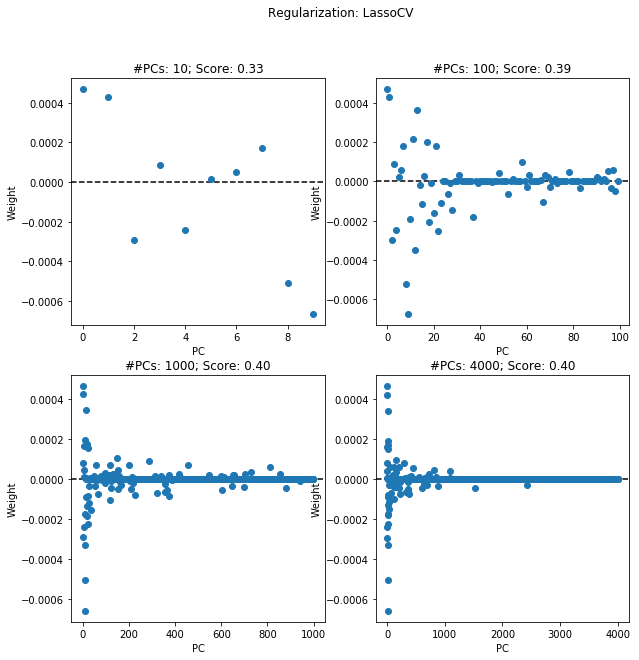

In [69]:
plt.figure(figsize=(10,10))

for i, model in enumerate(models):
    plt.subplot(2,2,i+1)
    plt.axhline(0,color='k',linestyle='--')
    plt.plot(model['model'].coef_,'o')
    plt.title ('#PCs: {}; Score: {:.2f}'.format(model['num_pcs'], model['score']))
    plt.ylabel('Weight')
    plt.xlabel('PC')
    
plt.suptitle('Regularization: LassoCV')

In [35]:
Y_glm = fictrac_interp
X_glm_1000 = pca_loadings[:,:1000]

In [50]:
t0 = time()
model_1000 = LassoCV()
model_1000.fit(X_glm_1000, Y_glm)
print('Duration: {} sec'.format(time()-t0))

NameError: name 'X_glm_100' is not defined

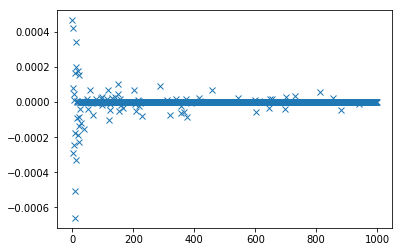

In [48]:
plt.plot(model_1000.coef_,'x')

In [49]:
model_1000.score(X_glm_1000,Y_glm)

0.40009402891821844

In [26]:
pca_scores_reshaped = np.reshape(pca_scores, (-1,dims['y'],dims['x']))
print('new shape: {}'.format(pca_scores_reshaped.shape))

new shape: (4128, 128, 92)


# Switching to statsmodels for link function

In [194]:
X_glm = sm.add_constant(np.nan_to_num(pca_loadings[:,:100]), prepend=False)

In [195]:
Y_glm = fictrac_interp

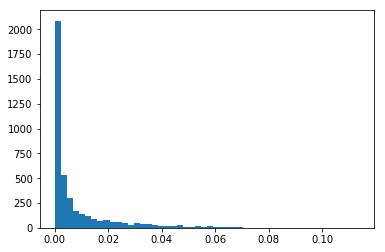

In [161]:
plt.hist(Y_glm,bins=50);

In [261]:
model = sm.GLM(y, X, family=sm.families.Poisson())

In [278]:
model_results = model.fit_regularized(method='elastic_net', L1_wt=1, alpha=.001)

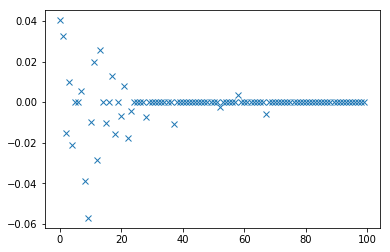

In [279]:
plt.plot(model_results.params[:-1],'x')

In [188]:
model_results = model.fit()

In [228]:
from sklearn.metrics import mean_squared_error

In [252]:
mean_squared_error(out,Y_glm)

0.0001137721573853367

In [239]:
from sklearn.model_selection import KFold

In [243]:
kf = KFold(n_splits=5, shuffle=True)

In [247]:
X = X_glm
y = Y_glm

In [259]:
MSE_all = []
i=0
for train_index, test_index in kf.split(X):
    if i==0:
        i+=1
        print(i)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = sm.add_constant(X_train, prepend=False)
        model = sm.GLM(y_train, X_train, family=sm.families.Poisson())
        MSE = []
        for alpha in [0,.1,.01,.001,.0001,.00001,.000001,.0000001]:
            model_results = model.fit_regularized(method='elastic_net', alpha=alpha)
            y_predicted = model_results.predict(X_test)
            MSE.append(mean_squared_error(y_predicted, y_test))
        MSE_all.append(MSE)
        #r2s.append(sklearn.metrics.r2_score(y_test, y_predicted))

1


In [257]:
MSE_all[0]

[0.00014965928500862812,
 0.010058965306480459,
 0.00024357615531764293,
 0.00014202493124954577,
 0.00014558185952353212]

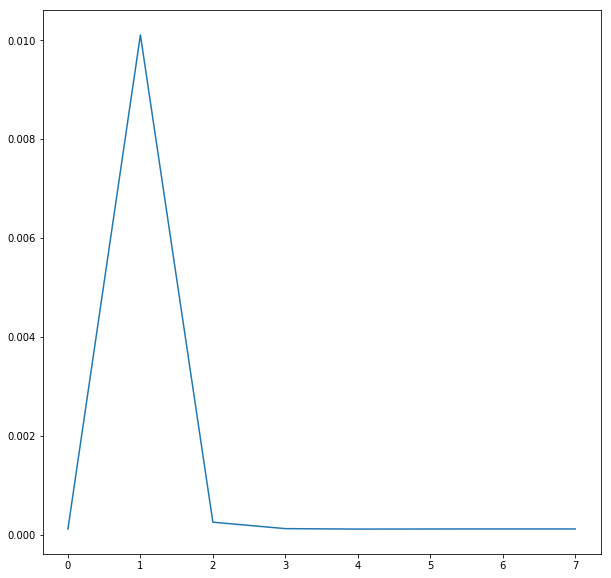

In [260]:
plt.figure(figsize=(10,10))
plt.plot(MSE_all[0])

In [250]:
np.mean(r2s)

0.34117338830967847

In [213]:
model_results = model.fit_regularized(method='elastic_net', alpha=.001)

In [215]:
out = model_results.predict(X_glm)

In [227]:
sklearn.metrics.r2_score(Y_glm, out)

0.3855329983355378

(2000, 2400)

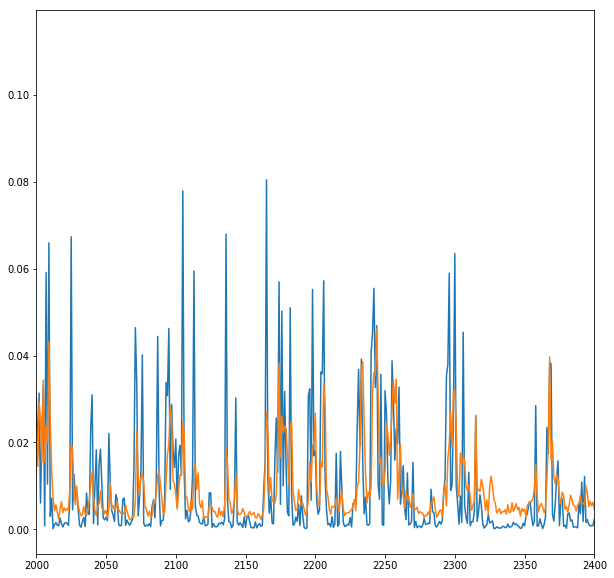

In [217]:
plt.figure(figsize=(10,10))
plt.plot(Y_glm)
plt.plot(out)
plt.xlim(2000,2400)

In [237]:
import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit_regularized(method='elastic_net', alpha=.001)
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [238]:
cross_val_score(SMWrapper(sm.GLM), X_glm, Y_glm, scoring='r2')

array([0.20644287, 0.33814884, 0.2989024 ])